In [ ]:
import pandas as pd
from google.colab import drive
import tensorflow
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

drive.mount('/content/drive/')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/results/results_sample_data_2.csv")

Mounted at /content/drive/


In [ ]:

df.Class = df.Class.astype(str)
datagen = ImageDataGenerator()

target_size=(128,128)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Image_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='sparse',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Image_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='sparse',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)


Found 4236 validated image filenames belonging to 5 classes.
Found 1059 validated image filenames belonging to 5 classes.


In [ ]:
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2L(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(train_data_generator,
                    steps_per_epoch=4236   //64,
                    epochs = 20,
                    validation_data=val_data_generator,
                    validation_steps= 1059 // 64,
                    callbacks = [callback])

473176280/473176280 [==============================] - 3s 0us/step


Epoch 1/20
66/66 [==============================] - 1970s 28s/step - loss: 0.8460 - accuracy: 0.6637 - val_loss: 0.3751 - val_accuracy: 0.8369
Epoch 2/20
66/66 [==============================] - 78s 1s/step - loss: 0.3518 - accuracy: 0.8603 - val_loss: 0.2722 - val_accuracy: 0.8887
Epoch 3/20
66/66 [==============================] - 77s 1s/step - loss: 0.2452 - accuracy: 0.9017 - val_loss: 0.2232 - val_accuracy: 0.9062
Epoch 4/20
66/66 [==============================] - 88s 1s/step - loss: 0.1953 - accuracy: 0.9185 - val_loss: 0.1795 - val_accuracy: 0.9150
Epoch 5/20
66/66 [==============================] - 78s 1s/step - loss: 0.1734 - accuracy: 0.9291 - val_loss: 0.2035 - val_accuracy: 0.9307
Epoch 6/20
66/66 [==============================] - 77s 1s/step - loss: 0.1665 - accuracy: 0.9317 - val_loss: 0.1970 - val_accuracy: 0.9355
Epoch 7/20
66/66 [==============================] - 78s 1s/step - loss: 0.1441 - accuracy: 0.9408 - val_loss: 0.1883 - val_accuracy: 0.9385
Epoch 8/20
66/66 

<ipython-input-4-55f5fac8f79b>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(val_data_generator, 1059 // 64+1)


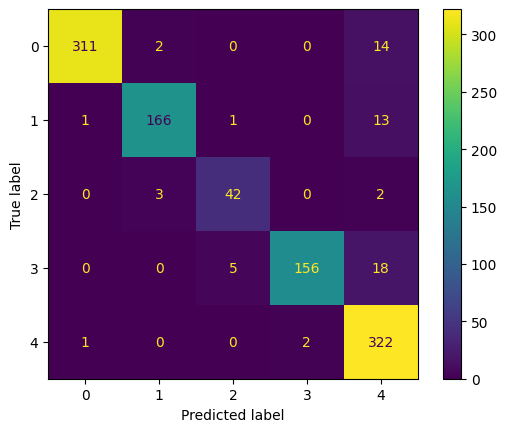

In [ ]:
y_pred = model.predict_generator(val_data_generator, 1059 // 64+1)
Y_pred = np.argmax(y_pred, axis=1)


confusion_matrix = confusion_matrix(val_data_generator.classes, Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [ ]:
print(classification_report(val_data_generator.classes, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       327
           1       0.97      0.92      0.94       181
           2       0.88      0.89      0.88        47
           3       0.99      0.87      0.93       179
           4       0.87      0.99      0.93       325

    accuracy                           0.94      1059
   macro avg       0.94      0.92      0.93      1059
weighted avg       0.95      0.94      0.94      1059



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(val_data_generator.classes, Y_pred)

0.9414542020774316